In [22]:
import glob
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get
import pandas
from skimage.measure import label, regionprops
import numpy as np

crop_cutoff = 960

ff = lambda *args: compose(*args[::-1])

crop = ff(
    PIL.Image.open,
    lambda image: (image.crop(box=(0, 0, image.size[0], crop_cutoff)),
                   image.crop(box=(0, crop_cutoff, image.size[0], image.size[1]))),

)

repair_string = lambda string: float('10' if string == 'mum' else string.replace('pm', ''))


string_data = ff(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
#    lambda data: dict(string=data)
    get([1, 3, -1]),
    lambda data: dict(scale=repair_string(data[0]),
                      date=data[1].replace('-', ''),
                      time=data[2])
)

scale_pixels = ff(
    np.array,
    lambda data: data if len(data.shape) == 2 else data[...,0],
    lambda data: label(data, background=0),
    regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1]
)

make_df = ff(
    glob.glob,
    sorted,
    map(lambda filename: (filename, crop(filename)[1])),
    map(lambda data: dict(filename=data[0],
                          scale_pixels=scale_pixels(data[1]),
                          **string_data(data[1]))),
    list,
    pandas.DataFrame
)

data = make_df('data/*.tif')
print(data[['filename', 'scale', 'scale_pixels']])

                             filename  scale  scale_pixels
0   data/1045_Steel_Nital-etch-01.tif   10.0           107
1   data/1045_Steel_Nital-etch-02.tif   10.0           161
2   data/1045_Steel_Nital-etch-03.tif   10.0           267
3   data/1045_Steel_Nital-etch-04.tif    1.0            80
4   data/1045_Steel_Nital-etch-05.tif    1.0            54
5   data/1045_Steel_Nital-etch-06.tif   10.0           161
6   data/1045_Steel_Nital-etch-07.tif   10.0           267
7   data/20150911_1045_Nital_etch.tif   10.0            54
8  data/20150911_1045_Nital_etch2.tif   10.0            54


data/1045_Steel_Nital-etch-03.tif


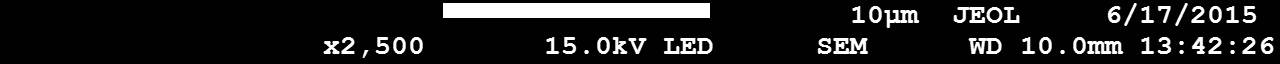

In [23]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
print(data.ix[2]['filename'])
crop(data.ix[2]['filename'])[1]

In [3]:
image = PIL.Image.open('data/1045_Steel_Nital-etch-01.tif')

In [4]:
image.size

(1280, 1024)

In [5]:
960 / 1024

0.9375

In [6]:
data['filename'][0]

'data/1045_Steel_Nital-etch-01.tif'